## Imports

In [1]:
# !pip install tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import os
import keras
import pickle
import pyarrow
import warnings
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

#set ggplot style
plt.style.use('ggplot')

warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


## Import Data

In [3]:
# Dynamic parameters
data_dir  = '../data/' + str(datetime.date(datetime.now()))
agg_file  = 'agg_data_{}.parquet.gzip'.format(datetime.date(datetime.now()))
trend_file  = 'trend_{}.csv'.format(datetime.date(datetime.now()))

# import data
df = pd.read_parquet(os.path.join(data_dir, agg_file))
# df = pd.read_csv(os.path.join(data_dir, trend_file), index_col=[0])

### Plotting functions

In [4]:
# Plots
def plot_scatter_2vars(tmp_df, x_col, y_col):
    tmp_df.plot(x=x_col, y=y_col, style='o')  
    plt.title('Scatter plot for correlation of ' + x_col + ' and ' + y_col)  
    plt.xlabel(x_col)  
    plt.ylabel(y_col)  
    plt.show()

def plot_scatter_1var(tmp_df, col):    
    tmp_df.groupby(['date'])[col].sum().plot(figsize=(10, 6), style='o') 
    plt.title('Regression on accumalitive Sum of Confirmed Cases')  
    plt.xlabel('date')  
    plt.ylabel('confirmed cases')  
    plt.show()

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


## Type Conversion

In [6]:
# Convert types
if 'new_confirmed_cases' in df.columns:
    for col in ['new_confirmed_cases', 'new_deaths', 'new_recoveries', 'currently_infected', 'delta']:
        df[col] = df[col].astype(float)   
else:
    for col in ['confirmed', 'deaths', 'recovered']:
        df[col] = df[col].replace('', 0).astype(float)

df['date'] = df['date'].astype('datetime64[ns]')

In [7]:
df.head()

,confirmed,country,date,deaths,province,recovered
37,1.0,South Korea,2020-01-22,0.0,,0.0
15,0.0,China,2020-01-22,0.0,Inner Mongolia,0.0
14,4.0,China,2020-01-22,0.0,Hunan,0.0
13,444.0,China,2020-01-22,0.0,Hubei,0.0
12,0.0,China,2020-01-22,0.0,Hong Kong,0.0


### Helper Functions

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Set Constants

In [10]:
# Convert types
if 'new_confirmed_cases' in df.columns:
    series = np.array(df.new_confirmed_cases)
    time = np.array(df.index)
else:
    series = np.array(df.confirmed)
    df = df.reset_index()
    time = np.array(df.index)


In [65]:
# time

In [25]:
split_time = 800
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 100


### Inspect Data

In [26]:
#Calculate range of trend data
def time_range(tmp_df):
    print('...', tmp_df['date'].min().date(), 'to',  tmp_df['date'].max().date())
    print('...', tmp_df['date'].min() - tmp_df['date'].max())
    print('\n')

print('Calulcating date ranges...\n')
time_range(df)

Calulcating date ranges...

... 2020-01-22 to 2020-02-07
... -16 days +00:00:00




In [27]:
df.head(2)

,index,confirmed,country,date,deaths,province,recovered
0,37,1.0,South Korea,2020-01-22,0.0,,0.0
1,15,0.0,China,2020-01-22,0.0,Inner Mongolia,0.0


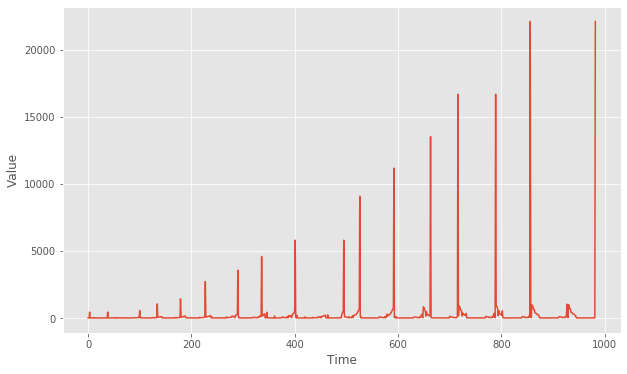

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [30]:
# time_train, x_train

In [31]:
time_valid, x_valid

(array([800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812,
        813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825,
        826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838,
        839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851,
        852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864,
        865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877,
        878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890,
        891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903,
        904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
        917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929,
        930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942,
        943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955,
        956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968,
        969, 970, 971, 972, 973, 974, 975, 976, 977

## Find Optimal Learning Rate

In [32]:
'''
Train a model using LearningRateScheduler to find the be 
learning rate
'''
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 250
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"], verbose=2)
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(800,)
Epoch 1/150
3/3 [==============================] - 4s 1s/step - loss: 170.3515 - mae: 168.5140
Epoch 2/150
3/3 [==============================] - 1s 187ms/step - loss: 128.1803 - mae: 168.4945
Epoch 3/150
3/3 [==============================] - 1s 183ms/step - loss: 129.0999 - mae: 168.4584
Epoch 4/150
3/3 [==============================] - 1s 183ms/step - loss: 128.7544 - mae: 168.4076
Epoch 5/150
3/3 [==============================] - 1s 196ms/step - loss: 129.7329 - mae: 168.3443
Epoch 6/150
3/3 [==============================] - 1s 193ms/step - loss: 129.2442 - mae: 168.2696
Epoch 7/150
3/3 [==============================] - 1s 181ms/step - loss: 129.2926 - mae: 168.1827
Epoch 8/150
3/3 [==============================] - 1s 184ms/step - loss: 128.4791 - mae: 168.0825
Epoch 9/150
3/3 [==============================] - 1s 181ms/step - loss: 128.2934 - mae: 167.9655
Epoch 10/150
3/3 [==

[1e-06, 0.0001, 0, 2000]

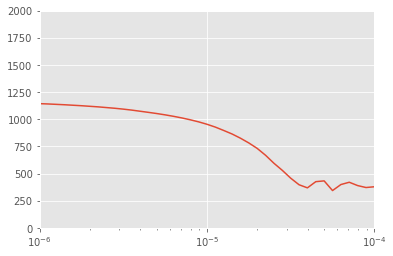

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 2000])

## Retrain model with Optimal LR

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=30, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=10, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.2)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)

Epoch 1/200
26/26 [==============================] - 8s 293ms/step - loss: 170.7283 - mae: 168.6056
Epoch 2/200
26/26 [==============================] - 1s 56ms/step - loss: 165.9271 - mae: 168.6049
Epoch 3/200
26/26 [==============================] - 1s 54ms/step - loss: 166.0682 - mae: 168.6042
Epoch 4/200
26/26 [==============================] - 1s 50ms/step - loss: 163.5668 - mae: 168.6035
Epoch 5/200
26/26 [==============================] - 1s 48ms/step - loss: 162.8862 - mae: 168.6029
Epoch 6/200
26/26 [==============================] - 1s 48ms/step - loss: 164.7575 - mae: 168.6022
Epoch 7/200
11/26 [===========>..................] - ETA: 0s - loss: 70.6298 - mae: 71.1061

KeyboardInterrupt: 

## Forecast

In [39]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

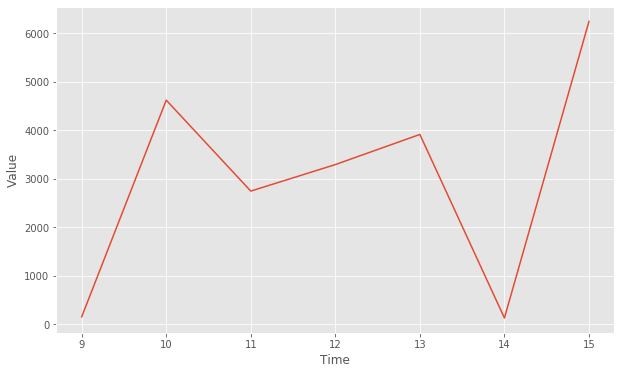

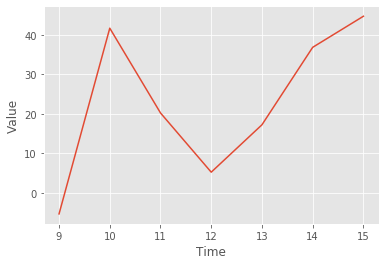

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2991.511

In [23]:
print(rnn_forecast)

[-5.3839865 41.679356  20.199596   5.193898  17.201918  36.827785
 44.704105 ]
